# (05) Neural $\beta$ alignment

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
path = results_dir()
path = pathlib.Path(path)

fit_names = set()
for p in path.rglob('**/*transl1*'):
    if p.is_dir():
        fit_names.add(p.name)
fit_names = sorted(fit_names)
fit_names

['transl1_nf-420_beta-0.5_(2023_05_02,15:00)',
 'transl1_nf-420_beta-10_(2023_05_04,09:20)',
 'transl1_nf-420_beta-1_(2023_05_02,22:02)']

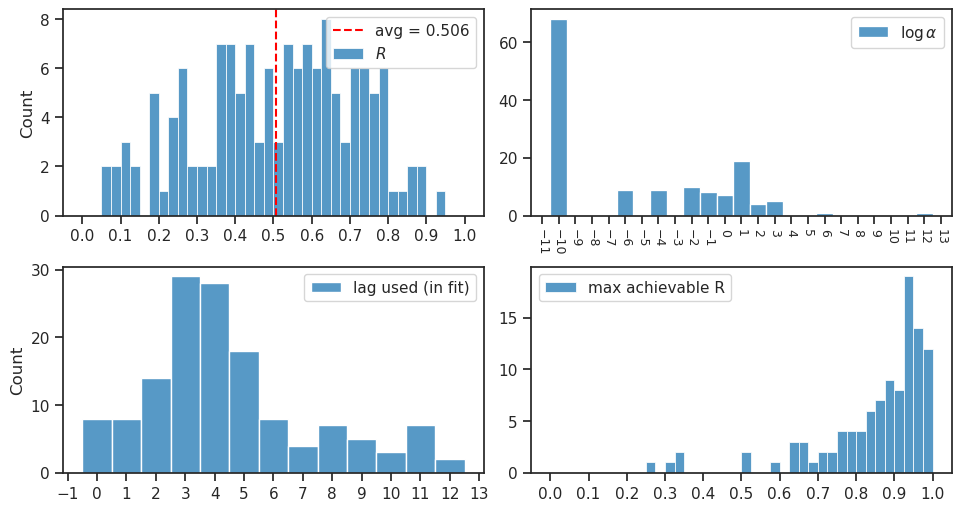

141

In [4]:
df, df_all, ro_all, args, tr = summarize_neural_fits(
    fit_name=fit_names[1], device='cuda')
_ = show_neural_results(df)
len(df)

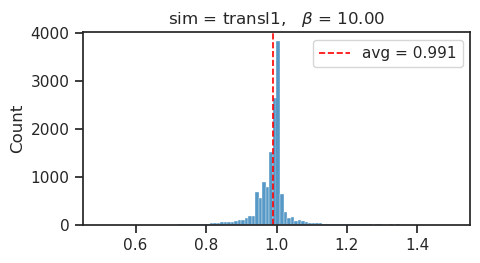

In [5]:
all_norms = to_np(torch.cat(
    tr.model.all_lognorm).exp())
avg_norms = all_norms.mean()

fig, ax = create_figure(1, 1, (5, 2.5))
sns.histplot(all_norms, bins=np.linspace(0.5, 1.5, 101), ax=ax)
ax.axvline(avg_norms, color='r', ls='--', lw=1.2, label=f'avg = {avg_norms:0.3f}')
title = f"sim = {tr.model.cfg.sim},   " + r"$\beta$ = " + f"{tr.cfg.kl_beta:0.2f}"
ax.set_title(title, fontsize=12)
ax.legend()
plt.show()

In [6]:
%%time

data, loss = tr.forward('vld', freeze=False, use_ema=False)
data_trn, _ = tr.forward('trn', freeze=True, use_ema=False)
data_vld, _ = tr.forward('vld', freeze=True, use_ema=False)
data_tst, _ = tr.forward('tst', freeze=True, use_ema=False)

CPU times: user 5min 27s, sys: 55.5 s, total: 6min 23s
Wall time: 6min 22s


In [7]:
loss['epe'].mean(), loss['kl'].mean(), loss['epe'].mean() + loss['kl'].mean()

(57.728325, 2.5419304, 60.270256)

In [8]:
list(data_trn)

['x', 'y', 'z']

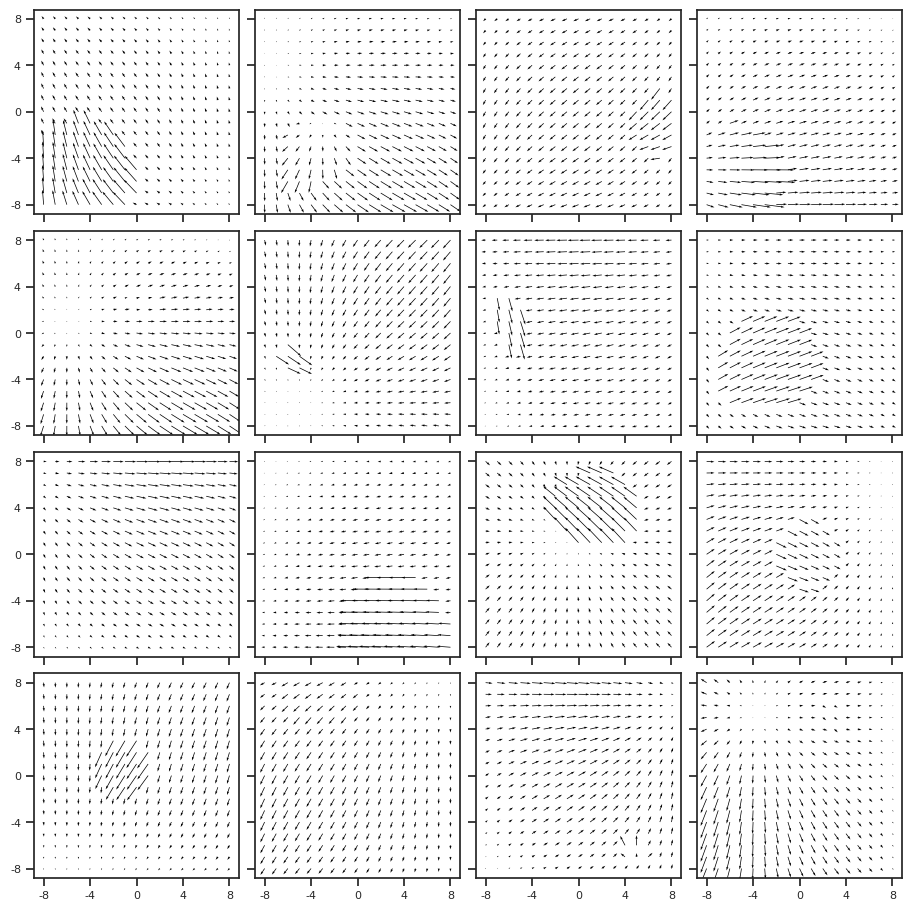

In [9]:
show_opticflow(data_trn['x']);

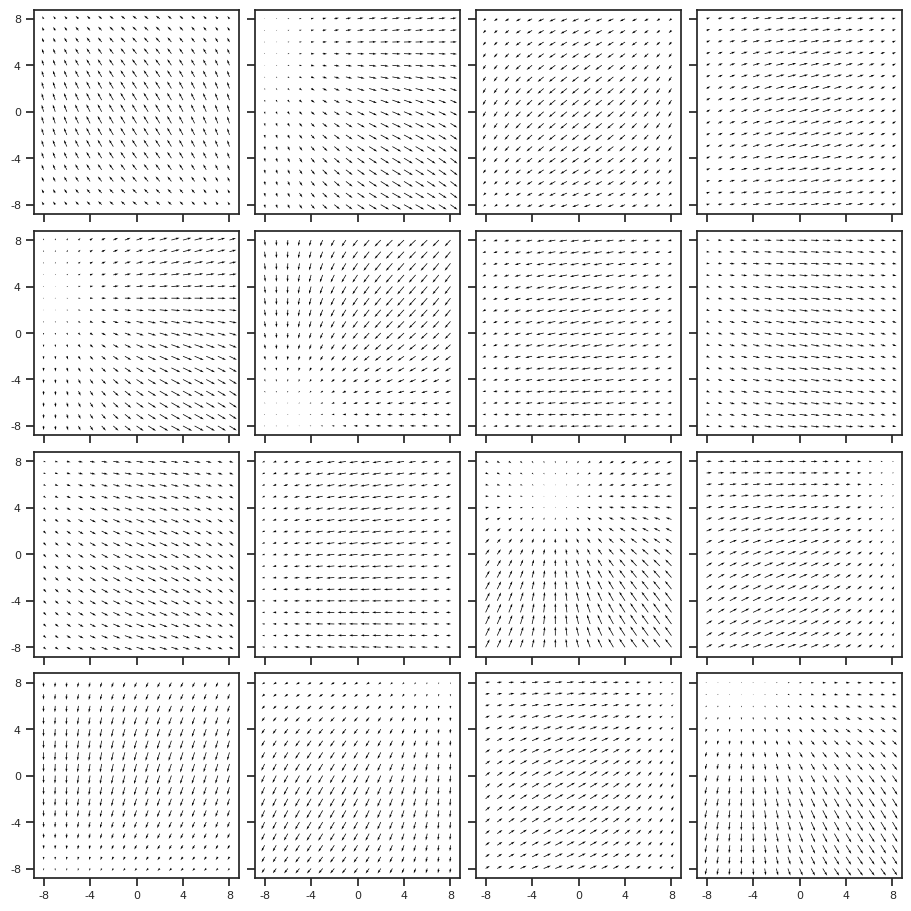

In [10]:
show_opticflow(data_trn['y']);

In [11]:
f = tr.dl_vld.dataset.f + tr.dl_vld.dataset.f_aux
g = np.concatenate([
    tr.dl_vld.dataset.g,
    tr.dl_vld.dataset.g_aux,
], axis=1)
g_tst = np.concatenate([
    tr.dl_tst.dataset.g,
    tr.dl_tst.dataset.g_aux,
], axis=1)
len(f), g.shape, g_tst.shape

(33, (75000, 33), (75000, 33))

In [12]:
lr = sk_linear.LinearRegression().fit(data_vld['z'], g)
pred = lr.predict(data_tst['z'])
r2 = sk_metric.r2_score(
    y_true=g_tst,
    y_pred=pred,
    multioutput='raw_values',
)
print(r2.mean(), '\n\n', list(zip(f, np.round(r2 * 100, 1))))

0.36798579300595124 


[
    ('fix_x', 64.5),
    ('fix_y', 69.5),
    ('slf_v_norm', 96.0),
    ('slf_v_theta', 61.1),
    ('slf_v_phi', 67.7),
    ('obj0_alpha_x', 20.5),
    ('obj0_alpha_y', 22.6),
    ('obj0_distance', 31.4),
    ('obj0_v_norm', 21.2),
    ('obj0_v_theta', -0.0),
    ('obj0_v_phi', 2.0),
    ('slf_v_x', 94.6),
    ('slf_v_y', 95.3),
    ('slf_v_z', 60.7),
    ('obj0_size_eff', 40.7),
    ('obj0_size', 40.7),
    ('obj0_theta', 22.5),
    ('obj0_phi', 16.5),
    ('obj0_x', 29.1),
    ('obj0_y', 30.3),
    ('obj0_z', 16.5),
    ('obj0_dx', 20.3),
    ('obj0_dy', 22.6),
    ('obj0_dz', 16.5),
    ('obj0_v_x', 3.7),
    ('obj0_v_y', 5.9),
    ('obj0_v_z', 0.0),
    ('obj0_dv_x', 54.4),
    ('obj0_dv_y', 54.3),
    ('obj0_dv_z', 31.5),
    ('obj0_dv_norm', 42.6),
    ('obj0_dv_theta', 27.8),
    ('obj0_dv_phi', 31.3)
]

In [14]:
fr_all = {}
kappa = {}
poisson = False
for ro in tqdm(ro_all.values()):
    for idx, m in ro.mod.items():
        key = f"{ro.expt}_{idx}"
        fr = m.predict(data_trn['z'])
        if poisson:
            fr = np.maximum(fr, 0)
            fr = rng.poisson(fr)
        k = np.einsum(
            't, tijk -> ijk',
            fr, data_trn['x'],
        )
        k /= sp_lin.norm(k)
        fr_all[key] = fr
        kappa[key] = k

100%|███████████████████████████████████████████| 60/60 [00:43<00:00,  1.38it/s]


In [15]:
titles = np.array([
    f"{name}, r = {r}" for name, r in
    zip(list(kappa), np.round(df['perf'].values, 2))
])
kappa_cat = np.stack(list(kappa.values()))
kappa_cat.shape

(141, 2, 17, 17)

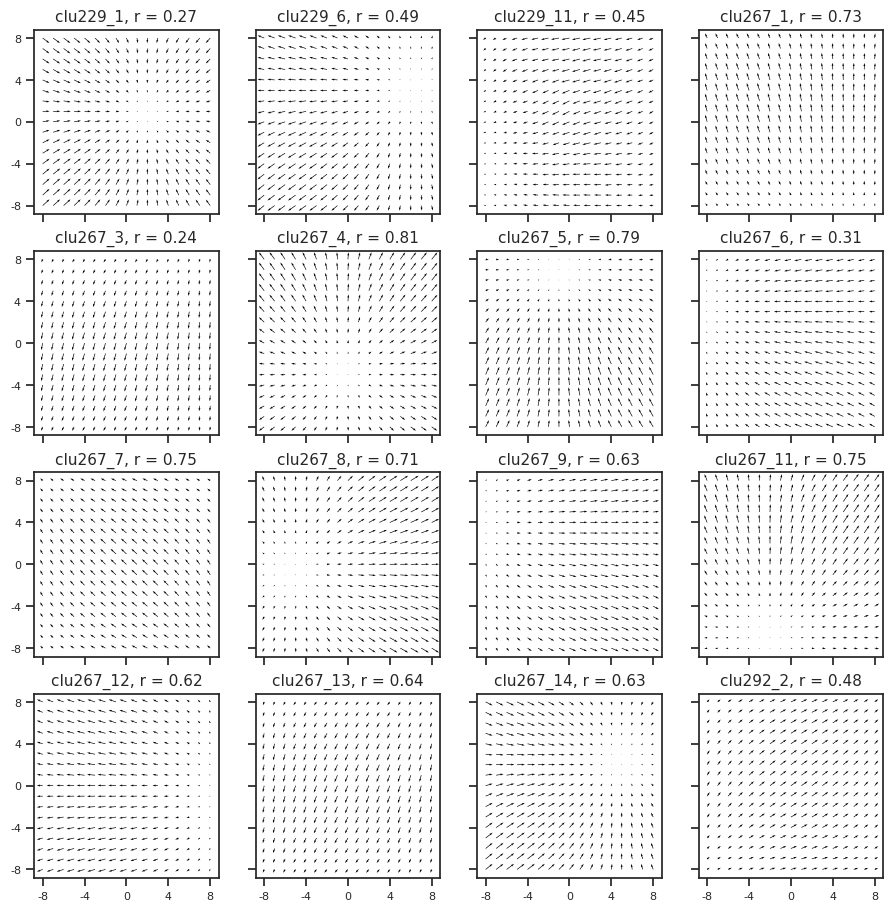

In [16]:
t = 64
intvl = range(t, t + 16)
show_opticflow(kappa_cat[intvl], titles=titles[intvl]);

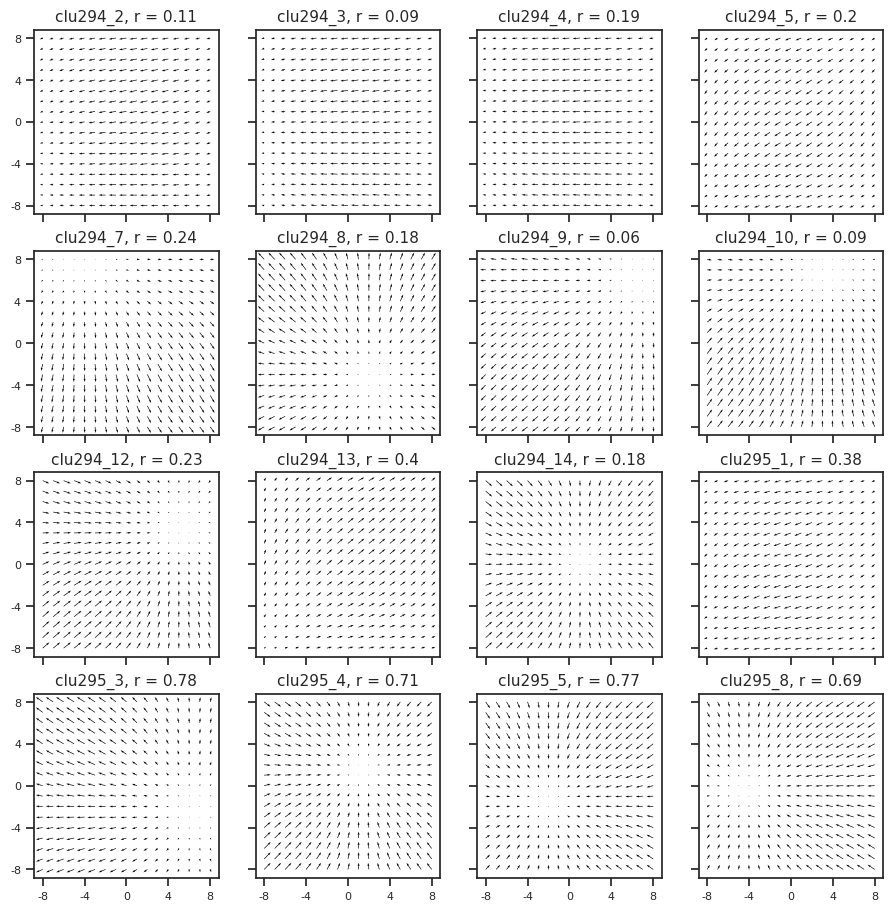

In [17]:
t = 96
intvl = range(t, t + 16)
show_opticflow(kappa_cat[intvl], titles=titles[intvl]);

In [35]:
expt, cell = 'clu267', 4
ro = ro_all[f'YUWEI_{expt}']
neural_data = ro.validate(cell)

neural_data['y'].sum() / (len(neural_data['y']) * 25e-3)

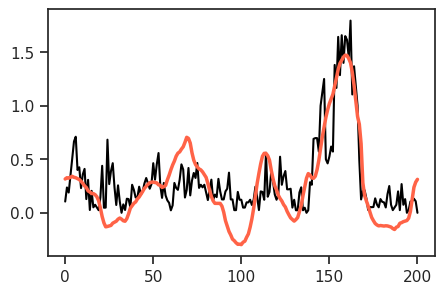

In [38]:
pred = ro.mod[cell].predict(neural_data['x_tst'])

plt.plot(data['y_tst'], color='k', lw=1.5)
plt.plot(pred, color='tomato', lw=2.5)

In [39]:
r = sp_stats.pearsonr(neural_data['y_tst'], pred)[0]
r2 = sk_metric.r2_score(neural_data['y_tst'], pred) * 100
r, r2

(0.7983578361937109, 52.34904914881766)

In [40]:
r / np.sqrt(ro_all['YUWEI_clu267'].max_perf[cell])

0.8148121913978432

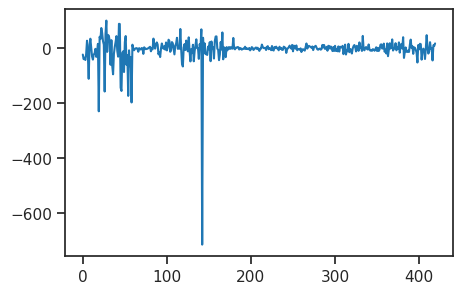

In [42]:
c = ro.mod[cell].coef_
plt.plot(c);

In [59]:
perm = sk_inspect.permutation_importance(
    estimator=ro.mod[cell],
    X=neural_data['x_tst'],
    y=neural_data['y_tst'],
    n_repeats=100,
    random_state=0,
)
perm_mu = np.maximum(0, perm['importances_mean'])
perm_sd = perm['importances_std']

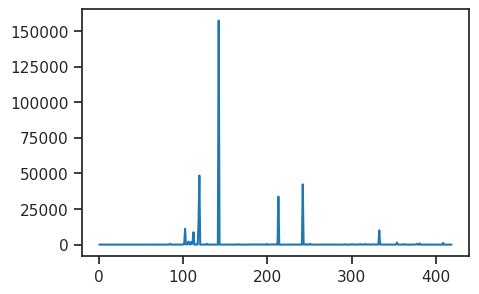

In [60]:
plt.plot(perm_mu)

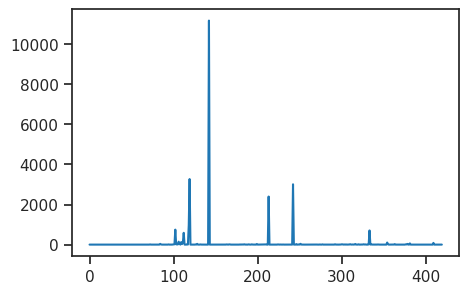

In [61]:
plt.plot(perm_sd)

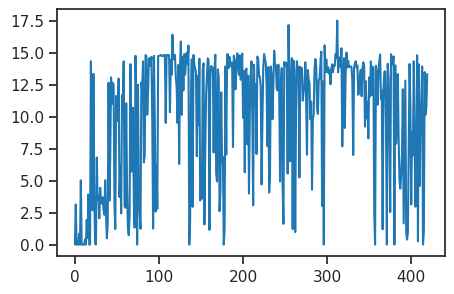

In [62]:
plt.plot(perm_mu / perm_sd)

In [64]:
p = perm_mu / perm_mu.sum()

In [69]:
1 - entropy_normalized(p, axis=0)

0.6673285056840212

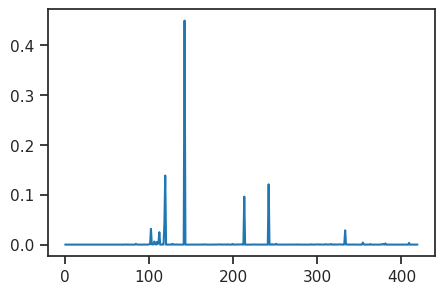

In [70]:
plt.plot(p)

In [73]:
important_latents = np.argsort(p)[::-1]
important_latents[:5]

array([142, 119, 242, 213, 118])

In [80]:
test = np.zeros(420)
test[133] = 1
test /= sum(test)
1 - entropy_normalized(test, axis=0)

1.0

In [81]:
test = np.ones(420)
test /= sum(test)
1 - entropy_normalized(test, axis=0)

1.1102230246251565e-16

In [82]:
val, loss = tr.validate(use_ema=False)

In [86]:
val['regr/mi'].shape

(11, 420)

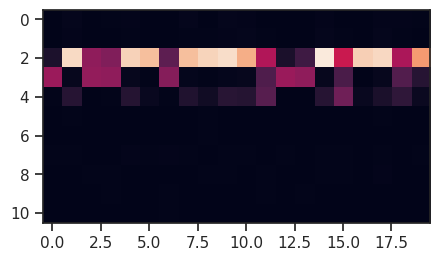

In [100]:
plt.imshow(val['regr/mi'][:, important_latents[:20]])

In [99]:
tr.dl_tst.dataset.f

['fix_x',
 'fix_y',
 'slf_v_norm',
 'slf_v_theta',
 'slf_v_phi',
 'obj0_alpha_x',
 'obj0_alpha_y',
 'obj0_distance',
 'obj0_v_norm',
 'obj0_v_theta',
 'obj0_v_phi']

In [ ]:
shape = (len(f), data_vld['z'].shape[1])
importances = np.zeros(shape)
importances_sd = np.zeros(shape)

for i in tqdm(range(len(f))):
    _lr = sk_linear.LinearRegression().fit(
        data_vld['z'], g[:, i])
    result = sk_inspect.permutation_importance(
        estimator=_lr,
        X=data_tst['z'],
        y=g_tst[:, i],
        n_repeats=5,
        random_state=0,
    )
    importances[i] = result.importances_mean
    importances_sd[i] = result.importances_std

 24%|██▍       | 8/33 [13:25<41:23, 99.35s/it] 